In [2]:
import pandas as pd
import numpy as np
import gc

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [9]:
img_features_path = '/home/tstrebel/assets/rnsa-pneumonia/rnsa-img-features.csv'

df = pd.read_csv(img_features_path, index_col='index')

df_train_val = df[df.split.isin(['train', 'test'])]
df_test = df[df.split == 'test']

del df

_ = gc.collect()

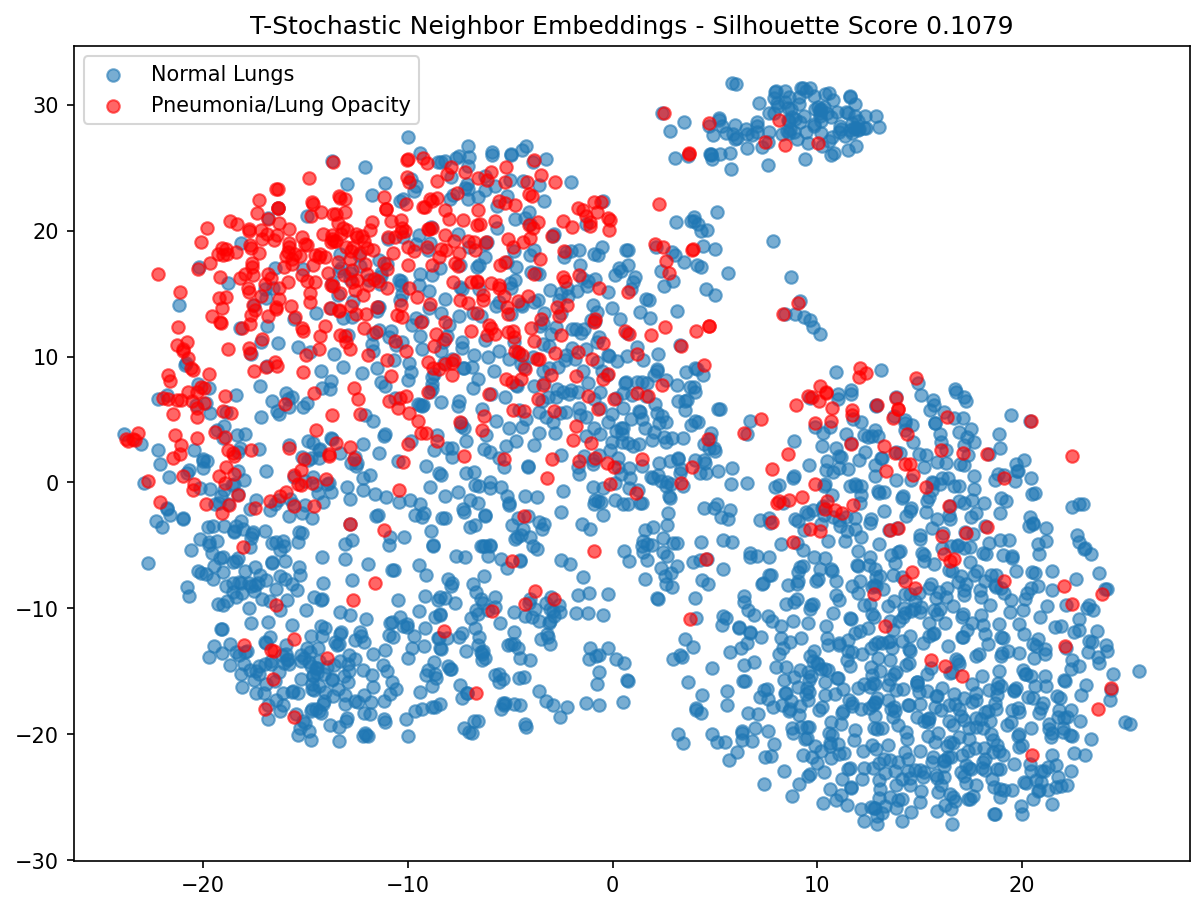

<Figure size 432x288 with 0 Axes>

In [8]:
from sklearn.metrics import silhouette_score

targets = df_test.iloc[:, -2]

tsne = TSNE(n_components=2, 
            perplexity=50, 
            learning_rate=10, 
            early_exaggeration=40, 
            n_jobs=-1
           ).fit_transform(df_test.iloc[:, 1:-2])

ix_0 = np.where(targets == 0)[0]
ix_1 = np.where(targets == 1)[0]

sil_score = silhouette_score(tsne, targets)

figsize = np.array([6.4, 4.8]) * 1.5

_ = plt.figure(dpi=150, figsize=figsize)
plt.scatter(tsne[ix_0, 0], tsne[ix_0, 1], alpha=.6, label='Normal Lungs')
plt.scatter(tsne[ix_1, 0], tsne[ix_1, 1], alpha=.6, color='red', label='Pneumonia/Lung Opacity')
plt.title('T-Stochastic Neighbor Embeddings - Silhouette Score {:.4f}'.format(sil_score))
plt.legend()
plt.show()
plt.tight_layout()
plt.show()

In [4]:
df_patients = pd.read_csv('/home/tstrebel/repos/umich-mads-capstone-project/assets/rnsa-patient-details.csv', index_col='index')
df_patients.head()

,patient_id,patient_age,patient_sex,view_position,class,x,y,width,height,target,split
index,,,,,,,,,,,
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,PA,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,train
1,000924cf-0f8d-42bd-9158-1af53881a557,19,F,AP,Normal,NaN,NaN,NaN,NaN,0,train
2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F,AP,Lung Opacity,316.0,318.0,170.0,478.0,1,train
3,000fe35a-2649-43d4-b027-e67796d412e0,40,M,AP,Lung Opacity,570.0,282.0,269.0,409.0,1,train
4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M,PA,Lung Opacity,66.0,160.0,373.0,608.0,1,train


In [9]:
# Radiographic view defined terms: AP = Anterior/Posterior PA = Posterior/Anterior
import scipy.stats as st

pd.set_option("display.precision", 3)

def get_95_ci(data):
    mean = np.mean(data)
    return mean, *st.t.interval(alpha=0.95, df=len(data)-1, loc=mean, scale=st.sem(data)) 

def get_statistics(data, split=None):
    data = data.copy()
    data['view_position'] = data['view_position'].map({'AP':'Anterior/Posterior', 'PA':'Posterior/Anterior'})

    age = (data[['patient_age', 'class']]
     .groupby('class')
     .apply(lambda grp: get_95_ci(grp.patient_age))
     .to_frame()
     .apply(lambda x: {'Mean':x[0][0], 'Low':x[0][1], 'High':x[0][2]}, axis=1, result_type='expand')
    )

    sex = (data
           [['patient_sex', 'class']]
           .pivot_table(index='class', columns='patient_sex', values='patient_sex', aggfunc=len))

    view_position = (data
           [['view_position', 'class']]
           .pivot_table(index='class', columns='view_position', values='view_position', aggfunc=len))
    
    result = age.join(sex).join(view_position)
    arrs = [['Age', 'Age 95% CI', 'Age 95% CI', 'Sex', 'Sex', 'View Position', 'View Position'], result.columns.tolist()]
    result.columns = pd.MultiIndex.from_arrays(arrs)
    return pd.concat([result], keys=[split], names=['split'])

pd.concat([
    get_statistics(df_patients[df_patients['split'].isin(['train', 'val'])], split='Train-Val'),
    get_statistics(df_patients[df_patients['split'] == 'test'], split='Test')
])

Age Age 95% CI           Sex        \
                                          Mean        Low    High     F     M   
split     class                                                                 
Train-Val Lung Opacity                  45.557     45.091  46.022  2260  3151   
          No Lung Opacity / Not Normal  49.396     49.083  49.709  4609  6057   
          Normal                        44.896     44.534  45.258  3501  4438   
Test      Lung Opacity                  45.814     44.410  47.217   242   359   
          No Lung Opacity / Not Normal  48.754     47.809  49.700   502   653   
          Normal                        45.297     44.269  46.326   404   508   

                                            View Position                     
                                       Anterior/Posterior Posterior/Anterior  
split     class                                                               
Train-Val Lung Opacity                               4206               1205  
          No Lung Opacity / Not Normal               5276               5390  
          Normal                                     1449               6490  
Test      Lung Opacity                                458                143  
          No Lung Opacity / Not Normal                596                559  
          Normal                                      188                724